# Pytorch Image Reconstruction (Auto Encoder Model for VGG)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from torchvision.utils import save_image
from torch.utils.data import Dataset
import natsort
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset for Task

Our task is to create an autoencoder based on VGG19 that reduces images to a latent space and then upsamples them back to original size. This will essentially train a network to take information from a dense, compressed state in the smaller hidden layers to create more complete images.

In [3]:


# install pillow
# !pip install Pillow -U
# !pip install natsort -U
# !pip install ipywidgets -U

In [4]:
# # download and unzip dataset o train
# !mkdir dataset/train
# %cd dataset/train
# !wget http://images.cocodataset.org/zips/train2014.zip
# !unzip -qq train2014.zip 
# %cd ../..

In [5]:
#Image Helper Functions


imsize = 512 if torch.cuda.is_available() else 256

preprocess = transforms.Compose([
          transforms.Resize(imsize),
          transforms.CenterCrop(imsize),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])


unloader = transforms.ToPILImage()  # reconvert into PIL image

def image_to_tensor(filename):
    input_image = Image.open(filename)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_batch.to(device)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it

    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
      ) 
    image = inv_normalize(image) # inverse the normalization we did on the image

    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    

def imsave(tensor, filename):
    image = tensor.cpu().clone()
    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
    ) 
    image = inv_normalize(image)

    save_image(image, filename)

In [6]:
# training dataset


# Custom UnsupervisedImageFolder class

class UnsupervisedImageFolder(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        all_imgs = os.listdir(root)
        self.total_imgs = natsort.natsorted(all_imgs)
    
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.root, self.total_imgs[idx])
        img = Image.open(img_loc).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __repr__(self):
        fmt_str = 'Unsupervised Image Dataset' + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

TRAIN_PATH='dataset/train2014/'
TEST_PATH='dataset/test/'
BATCH_SIZE=4

train_dataset = UnsupervisedImageFolder(TRAIN_PATH, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = UnsupervisedImageFolder(TEST_PATH, transform=preprocess)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Unsupervised Image Dataset
    Number of datapoints: 82783
    Root Location: dataset/train2014/
    Transforms (if any): Compose(
                             Resize(size=512, interpolation=bilinear, max_size=None, antialias=None)
                             CenterCrop(size=(512, 512))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

torch.Size([3, 512, 512])


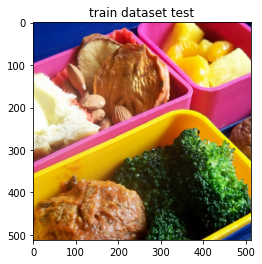

In [7]:
# Dataset tests
print(train_dataset)
print(train_dataset[0].shape)
imshow(train_dataset[0], "train dataset test")

torch.Size([4, 3, 512, 512])
torch.Size([3, 512, 512])


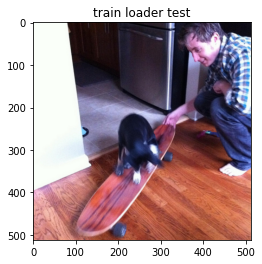

In [41]:
img_batch = next(iter(train_loader))
print(img_batch.shape)
img = img_batch[0]
print(img.shape)
imshow(img, "train loader test")

## Model Architecture

In [9]:
# model = torchvision.models.vgg19(pretrained=False)

# model_path = 'models/vgg19-dcbb9e9d.pth'
# model.load_state_dict(torch.load(model_path), strict=False)
# model.eval()
# model.to(device)

Here, I'm choosing to ignore instance normalization, which is seen to greatly increase model performce, will come back later

Using upsample code for maxpool layers and decov layers
https://github.com/mtliba/360-images-VGG-based-Autoencoder-Pytorch/blob/master/model.py 

In [38]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor)
        return x

class VGGAutoEncoder(torch.nn.Module):
    def __init__(self, rep_layer='relu_5_1', vgg_version='vgg19', vgg_path=None):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = nn.Sequential()

        vgg = torch.hub.load('pytorch/vision:v0.10.0', vgg_version, pretrained=False if not vgg_path else True)
        if vgg_path:
            vgg.load_state_dict(torch.load(vgg_path), strict=False)

        i = 1
        j = 1
        for layer in vgg.features.children():
            if isinstance(layer, nn.Conv2d):
                name = f"conv{i}_{j}"
            elif isinstance(layer, nn.MaxPool2d):
                name = f"maxpool_{i}"
                i += 1
                j = 1

            elif isinstance(layer, nn.ReLU):
                name = f"relu_{i}_{j}"
                j += 1
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            self.encoder.add_module(name, layer)
            if name == rep_layer: break

        self.decoder = nn.Sequential()
        
        for name, layer in list(self.encoder.named_children())[::-1]:
            new_name, new_layer = None, None
            if isinstance(layer, nn.Conv2d):
                new_name = "de" + name
                new_layer = nn.ConvTranspose2d(layer.out_channels, layer.in_channels, kernel_size=layer.kernel_size,stride=layer.stride, padding=layer.padding)
            elif isinstance(layer, nn.MaxPool2d):
                new_name = "upsample_" + name[-1]
                new_layer = Interpolate(scale_factor=2)
            elif isinstance(layer, nn.ReLU):
                new_name = "mir_"+ name
                new_layer = nn.ReLU(inplace=True)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            self.decoder.add_module(new_name, new_layer)
        print(self.encoder, self.decoder)

            
    def forward(self, x):
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
        return dec_x, enc_x
            

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU(inplace=True)
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU(inplace=True)
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU(inplace=True)
  (conv3_4): Con

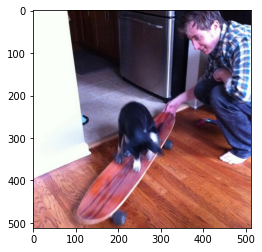

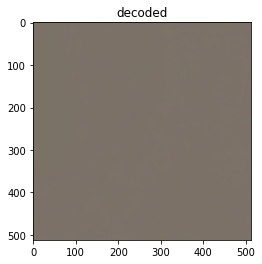

In [42]:
model_path = 'models/vgg19-dcbb9e9d.pth'

ae = VGGAutoEncoder(rep_layer="relu_4_1",vgg_path=model_path)

dec, enc = ae(img.unsqueeze(0))

print(img.shape, enc.shape, dec.shape)
imshow(img)
imshow(dec, "decoded")